# Framingham Risk Scores (By Formula)

In [1]:
import pandas as pd
import numpy as np

# Load the CSV dataset
file_path_csv = r"C:\Users\Merin\OneDrive\Desktop\Framingham_DataSet 1.csv"
data_csv = pd.read_csv(file_path_csv)

# Define coefficients for men and women
coefficients_men = {
    "intercept": -19.7709560,
    "age": 0.3743307,
    "age_squared": -0.0021165,
    "totChol": 0.0258102,
    "sysBP": 0.0156953,
    "CURSMOKE": 0.5583013,
    "ECG_LVH": 1.0529656,  # Assuming 1 if evidence of LVH, 0 otherwise
    "diabetes": 0.6020336,
    "chol_age": -0.0003619
}

coefficients_women = {
    "intercept": -16.4598427,
    "age": 0.2665693,
    "age_squared": -0.0012655,
    "totChol": 0.0160593,
    "sysBP": 0.0144265,
    "CURSMOKE": 0.0395348,
    "ECG_LVH": 0.8745090,
    "diabetes": 0.6821258,
    "chol_age": -0.0002157
}

def calculate_risk_score(row, coefficients):
    age = row['age']
    age_squared = age ** 2
    totChol = row['totChol']
    sysBP = row['sysBP']
    CURSMOKE = row['CURSMOKE']
    diabetes = row['diabetes']
    # Assuming ECG_LVH is not provided, setting it to 0
    ECG_LVH = 0  
    chol_age = totChol * age

    risk_score = (coefficients["intercept"] +
                  coefficients["age"] * age +
                  coefficients["age_squared"] * age_squared +
                  coefficients["totChol"] * totChol +
                  coefficients["sysBP"] * sysBP +
                  coefficients["CURSMOKE"] * CURSMOKE +
                  coefficients["ECG_LVH"] * ECG_LVH +
                  coefficients["diabetes"] * diabetes +
                  coefficients["chol_age"] * chol_age)
    return risk_score

def calculate_probability(risk_score):
    return 1 / (1 + np.exp(-risk_score))

# Remove rows with missing values
data_csv_clean = data_csv.dropna(subset=['age', 'sysBP', 'totChol', 'CURSMOKE', 'diabetes'])

# Apply the calculation to each row in the cleaned dataset
data_csv_clean['risk_score'] = data_csv_clean.apply(
    lambda row: calculate_risk_score(row, coefficients_men if row['sex'] == 1 else coefficients_women),
    axis=1
)

data_csv_clean['probability'] = data_csv_clean['risk_score'].apply(calculate_probability)

# Categorize risk
threshold = 0.2  # Example threshold for high risk
data_csv_clean['TenYearFRS'] = data_csv_clean['probability'].apply(lambda x: 1 if x > threshold else 0)

# Display the first few rows with the calculated scores, probabilities, and risk categorization
result = data_csv_clean[['age', 'sysBP', 'totChol', 'CURSMOKE', 'diabetes', 'risk_score', 'probability', 'TenYearFRS']]

# Display the results
result.head(10)


C:\Users\Merin\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\1089431219.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_csv_clean['risk_score'] = data_csv_clean.apply(
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\1089431219.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_csv_clean['prob

,age,sysBP,totChol,CURSMOKE,diabetes,risk_score,probability,TenYearFRS
0,39.0,106.0,195.0,0.0,0.0,-4.446814,0.011580,0
1,52.0,121.0,209.0,0.0,0.0,-2.668442,0.064861,0
2,46.0,121.0,250.0,0.0,0.0,-3.595571,0.026712,0
3,52.0,105.0,260.0,0.0,0.0,-3.246215,0.037463,0
4,58.0,108.0,237.0,0.0,0.0,-2.856861,0.054328,0
5,48.0,127.5,245.0,1.0,0.0,-2.052491,0.113801,0
6,54.0,141.0,283.0,1.0,0.0,-1.183743,0.234380,1
7,61.0,150.0,225.0,1.0,0.0,-2.051671,0.113884,0
8,67.0,183.0,232.0,1.0,0.0,-1.228028,0.226527,1
9,46.0,130.0,285.0,1.0,0.0,-3.211400,0.038739,0


In [2]:
# Add the 'TenYearFRS' column to the original dataset
data_csv['TenYearFRS'] = 0
data_csv.loc[data_csv_clean.index, 'TenYearFRS'] = data_csv_clean['TenYearFRS']

# Save the updated DataFrame to a new CSV file
output_file_path = r'C:\Users\Merin\Documents\FRS_Forumla.csv'
data_csv.to_csv(output_file_path, index=False)

print(f"Updated data saved to {output_file_path}")

Updated data saved to C:\Users\Merin\Documents\FRS_Forumla.csv


# Framingham Risk Scores (by Cox Proportional-Hazards Regression)

In [3]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt


In [4]:
# Load the dataset
df = pd.read_csv(r'C:\Users\Merin\Documents\FRS_Forumla.csv')
#r"C:\Users\Merin\OneDrive\Desktop\Framingham_DataSet 1.csv")

# Drop rows with missing values in relevant columns
df = df.dropna(subset=['age', 'totChol', 'sysBP', 'CURSMOKE', 'BMI', 'diabetes', 'TIMECVD', 'CVD'])

# Convert relevant columns to appropriate data types
df['sex'] = df['sex'].astype(int)
df['CVD'] = df['CVD'].astype(int)
df['diabetes'] = df['diabetes'].astype(int)
df['CURSMOKE'] = df['CURSMOKE'].astype(int)

#Split the dataset by sex:
df_men = df[df['sex'] == 1]
df_women = df[df['sex'] == 2]

#Fit the Cox proportional-hazards model:
def fit_cox_model(df):
    cph = CoxPHFitter()
    cph.fit(df, duration_col='TIMECVD', event_col='CVD', formula="age + totChol + BMI + sysBP + CURSMOKE + diabetes")
    return cph

cph_men = fit_cox_model(df_men)
cph_women = fit_cox_model(df_women)


In [5]:
#Calculate the baseline survival:
baseline_survival_men = cph_men.baseline_survival_
baseline_survival_women = cph_women.baseline_survival_

In [6]:
# Define a function to calculate the risk for each individual
def calculate_risk(df, cph, baseline_survival, time_horizon=3650):
    linear_predictor = cph.predict_partial_hazard(df)
    nearest_time_index = abs(baseline_survival.index - time_horizon).argmin()
    baseline_survival_at_time = baseline_survival.iloc[nearest_time_index]
    risk = 1 - np.exp(np.log(baseline_survival_at_time.values) * linear_predictor)
    return risk

# Use 10-year horizon (3650 days) for risk calculation
df_men['risk'] = calculate_risk(df_men, cph_men, baseline_survival_men)
df_women['risk'] = calculate_risk(df_women, cph_women, baseline_survival_women)


C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3082574299.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_men['risk'] = calculate_risk(df_men, cph_men, baseline_survival_men)
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3082574299.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_women['risk'] = calculate_risk(df_women, cph_women, baseline_survival_women)


In [7]:
#Create a scoring system:
def create_score_sheet(cph):
    score_sheet = {}
    for covariate in cph.params_.index:
        score_sheet[covariate] = cph.params_[covariate]
    return score_sheet

score_sheet_men = create_score_sheet(cph_men)
score_sheet_women = create_score_sheet(cph_women)

In [8]:
#Calculate heart age:
def calculate_heart_age(df, score_sheet, baseline_survival):
    normal_levels = {'age': 50, 'totChol': 200, 'BMI': 25, 'sysBP': 120, 'CURSMOKE': 0, 'diabetes': 0}
    linear_predictor_normal = sum(score_sheet[var] * normal_levels[var] for var in score_sheet)
    df['heart_age'] = 50 + (df['risk'] - linear_predictor_normal) / score_sheet['age']
    return df

df_men = calculate_heart_age(df_men, score_sheet_men, baseline_survival_men)
df_women = calculate_heart_age(df_women, score_sheet_women, baseline_survival_women)

C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\1018369634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heart_age'] = 50 + (df['risk'] - linear_predictor_normal) / score_sheet['age']
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\1018369634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heart_age'] = 50 + (df['risk'] - linear_predictor_normal) / score_sheet['age']


<lifelines.CoxPHFitter: fitted with 4898 total observations, 3258 right-censored observations>
             duration col = 'TIMECVD'
                event col = 'CVD'
      baseline estimation = breslow
   number of observations = 4898
number of events observed = 1640
   partial log-likelihood = -13231.40
         time fit was run = 2024-08-21 09:30:32 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.04      1.04      0.00            0.03            0.04                1.03                1.05
totChol    0.00      1.00      0.00            0.00            0.00                1.00                1.00
BMI        0.02      1.02      0.01            0.00            0.03                1.00                1.03
sysBP      0.01      1.01      0.00            0.01            0.01                1.01                1.01
CURSMOKE   0.32      1.38      0.05            0.22            0.42                1.25                1.53
diabetes   0.55      1.73      0.09            0.37            0.72                1.45                2.06

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 13.51 <0.005    135.80
totChol      0.00  7.12 <0.005     39.73
BMI          0.00  2.28   0.02      5.45
sysBP        0.00 10.20 <0.005     78.76
CURSMOKE     0.00  6.17 <0.005     30.49
diabetes     0.00  6.09 <0.005     29.69
---
Concordance = 0.66
Partial AIC = 26474.80
log-likelihood ratio test = 505.19 on 6 df
-log2(p) of ll-ratio test = 349.44

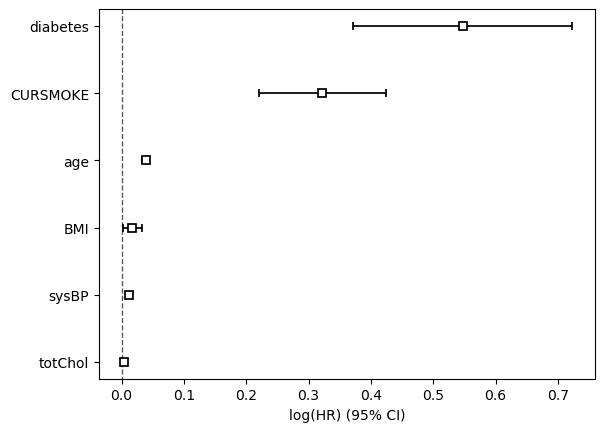

<lifelines.CoxPHFitter: fitted with 6275 total observations, 5123 right-censored observations>
             duration col = 'TIMECVD'
                event col = 'CVD'
      baseline estimation = breslow
   number of observations = 6275
number of events observed = 1152
   partial log-likelihood = -9498.74
         time fit was run = 2024-08-21 09:30:33 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.04      1.04      0.00            0.04            0.05                1.04                1.05
totChol    0.00      1.00      0.00            0.00            0.00                1.00                1.00
BMI        0.03      1.03      0.01            0.02            0.04                1.02                1.04
sysBP      0.02      1.02      0.00            0.01            0.02                1.01                1.02
CURSMOKE   0.36      1.44      0.07            0.23            0.49                1.26                1.63
diabetes   0.71      2.04      0.10            0.52            0.91                1.69                2.48

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 11.54 <0.005     99.89
totChol      0.00  4.02 <0.005     14.07
BMI          0.00  4.84 <0.005     19.56
sysBP        0.00 13.43 <0.005    134.26
CURSMOKE     0.00  5.48 <0.005     24.52
diabetes     0.00  7.30 <0.005     41.71
---
Concordance = 0.73
Partial AIC = 19009.48
log-likelihood ratio test = 767.69 on 6 df
-log2(p) of ll-ratio test = 537.59

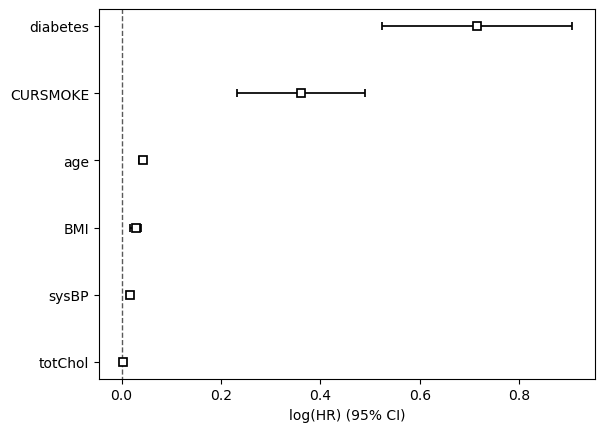

In [9]:
#Evaluate model performance:

def evaluate_model(cph, df):
    cph.print_summary()
    cph.plot()
    plt.show()

evaluate_model(cph_men, df_men)
evaluate_model(cph_women, df_women)

The output from the Cox proportional-hazards regression analysis for both men and women provides several important pieces of information:

# For Men
## Model Summary:
## Concordance: 
0.67. This value indicates the model's ability to correctly rank the survival times. A value of 1 indicates perfect prediction, while 0.5 indicates no better than random guessing.
### Partial AIC: 
26474.80. A lower value suggests a better-fitting model.
### Log-likelihood ratio test: 
505.19 on 6 degrees of freedom. This tests the overall significance of the model. A higher value indicates better model fit.
## Coefficients:
### Age (coef=0.04): 
Each additional year of age increases the risk of CVD by about 4%.
### Total Cholesterol (totChol, coef=0.00): 
Total cholesterol does not significantly affect the risk in this model.
### BMI (coef=0.02): 
Each unit increase in BMI increases the risk of CVD by about 2%.
### Systolic Blood Pressure (sysBP, coef=0.01): 
Each unit increase in systolic blood pressure increases the risk by about 1%.
### Smoking (CURSMOKE, coef=0.32): 
Being a smoker increases the risk of CVD by about 32%.
### Diabetes (coef=0.55): 
Having diabetes increases the risk of CVD by about 55%.
## Plot:
The plot shows the log hazard ratios (HR) and 95% confidence intervals for each variable. Variables with confidence intervals not crossing the vertical line at 0 are statistically significant.
# For Women
## Model Summary:
## Concordance: 
0.73. Indicates a better model fit compared to men.
### Partial AIC: 19009.48.
Lower than the men's model, suggesting a better fit.
### Log-likelihood ratio test: 
767.69 on 6 degrees of freedom. Indicates a significant model fit.
## Coefficients:
### Age (coef=0.04): 
Similar to men, each additional year increases the risk by about 4%.
### Total Cholesterol (totChol, coef=0.00): 
Not significant in this model.
### BMI (coef=0.02):
Each unit increase in BMI increases the risk by about 2%.
### Systolic Blood Pressure (sysBP, coef=0.02): 
Each unit increase in systolic blood pressure increases the risk by about 2%.
### Smoking (CURSMOKE, coef=0.36): 
Being a smoker increases the risk by about 36%.
###  Diabetes (coef=0.71): 
Having diabetes increases the risk by about 71%.
## Plot:
Similar to men, the plot shows the log hazard ratios and 95% confidence intervals. Again, significant variables are those whose confidence intervals do not cross the vertical line at 0.
# Interpretation:
### Concordance: 
The model for women has a higher concordance, indicating it is better at predicting CVD events compared to the model for men.
### Significance: 
Age, BMI, systolic blood pressure, smoking, and diabetes are significant predictors of CVD for both sexes. Total cholesterol is not significant in either model.
### Risk Increase: 
Diabetes and smoking show the largest increase in risk for both men and women.

Overall, the models indicate that age, BMI, systolic blood pressure, smoking, and diabetes are important predictors of cardiovascular disease risk, with the models fitting slightly better for women than for men.

C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3992412313.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_risk'] = normalize_risk(calculate_predicted_risk(test_data, cph))
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3992412313.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_risk'] = normalize_risk(calculate_predicted_risk(test_data, cph))
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3992412313.py:55: SettingWithCopyWarning: 
A value is trying to

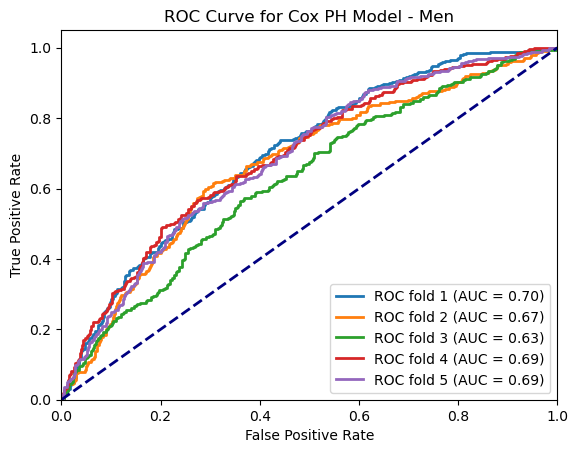

Cross-validation ROC AUC scores for Men: [0.7000127636038744, 0.670585557173277, 0.6263257575757576, 0.6928334539031746, 0.6859751412429378]
Mean ROC AUC score for Men: 0.6751465346998043


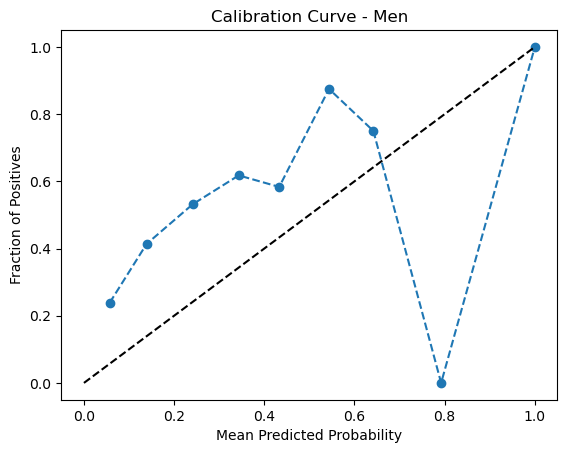

Calibration points for Men:
Mean Predicted: 0.06, Fraction of Positives: 0.24
Mean Predicted: 0.14, Fraction of Positives: 0.41
Mean Predicted: 0.24, Fraction of Positives: 0.53
Mean Predicted: 0.34, Fraction of Positives: 0.62
Mean Predicted: 0.43, Fraction of Positives: 0.58
Mean Predicted: 0.54, Fraction of Positives: 0.88
Mean Predicted: 0.64, Fraction of Positives: 0.75
Mean Predicted: 0.79, Fraction of Positives: 0.00
Mean Predicted: 1.00, Fraction of Positives: 1.00


C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3992412313.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_risk'] = normalize_risk(calculate_predicted_risk(test_data, cph))
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3992412313.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_risk'] = normalize_risk(calculate_predicted_risk(test_data, cph))
C:\Users\Merin\AppData\Local\Temp\ipykernel_2212\3992412313.py:55: SettingWithCopyWarning: 
A value is trying to

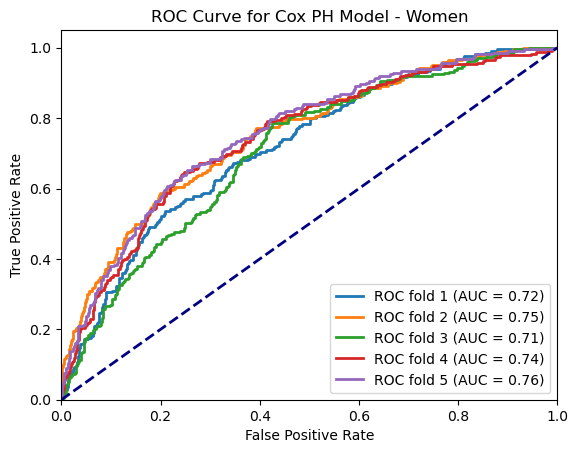

Cross-validation ROC AUC scores for Women: [0.7184302926603214, 0.7513455835718816, 0.7065842327977432, 0.7441009595327492, 0.756882025022244]
Mean ROC AUC score for Women: 0.7354686187169879


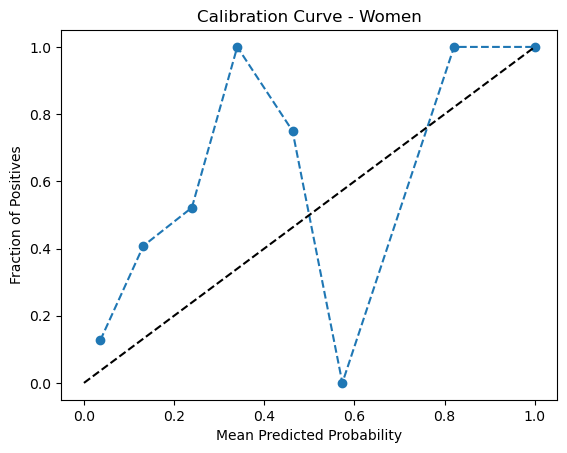

Calibration points for Women:
Mean Predicted: 0.04, Fraction of Positives: 0.13
Mean Predicted: 0.13, Fraction of Positives: 0.41
Mean Predicted: 0.24, Fraction of Positives: 0.52
Mean Predicted: 0.34, Fraction of Positives: 1.00
Mean Predicted: 0.46, Fraction of Positives: 0.75
Mean Predicted: 0.57, Fraction of Positives: 0.00
Mean Predicted: 0.82, Fraction of Positives: 1.00
Mean Predicted: 1.00, Fraction of Positives: 1.00


In [10]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.model_selection import KFold

# Load the dataset
file_path = r'C:\Users\Merin\Documents\FRS_Forumla.csv'  # Update the path as needed
df = pd.read_csv(file_path)

# Drop rows with missing values in relevant columns
df = df.dropna(subset=['age', 'totChol', 'sysBP', 'CURSMOKE', 'BMI', 'diabetes', 'TIMECVD', 'CVD'])

# Convert relevant columns to appropriate data types
df['sex'] = df['sex'].astype(int)
df['CVD'] = df['CVD'].astype(int)
df['diabetes'] = df['diabetes'].astype(int)
df['CURSMOKE'] = df['CURSMOKE'].astype(int)

# Split the dataset by sex
df_men = df[df['sex'] == 1]
df_women = df[df['sex'] == 2]

# Function to fit the Cox proportional-hazards model
def fit_cox_model(df):
    cph = CoxPHFitter()
    cph.fit(df, duration_col='TIMECVD', event_col='CVD', formula="age + totChol + BMI + sysBP + CURSMOKE + diabetes")
    return cph

# Function to calculate predicted risk
def calculate_predicted_risk(df, cph):
    return cph.predict_partial_hazard(df).values.flatten()

# Normalize the predicted risk to the range [0, 1]
def normalize_risk(predicted_risk):
    min_risk = predicted_risk.min()
    max_risk = predicted_risk.max()
    return (predicted_risk - min_risk) / (max_risk - min_risk)

# Function to perform cross-validation and plot ROC curve
def cross_val_roc_curve(df, title):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []
    
    plt.figure()
    
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]
        
        cph = fit_cox_model(train_data)
        test_data['predicted_risk'] = normalize_risk(calculate_predicted_risk(test_data, cph))
        
        fpr, tpr, _ = roc_curve(test_data['CVD'], test_data['predicted_risk'])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        
        plt.plot(fpr, tpr, lw=2, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Cox PH Model - {title}')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f'Cross-validation ROC AUC scores for {title}: {roc_auc_scores}')
    print(f'Mean ROC AUC score for {title}: {np.mean(roc_auc_scores)}')

    return test_data

# Function to plot calibration curve
def plot_calibration_curve(df, title):
    prob_true, prob_pred = calibration_curve(df['CVD'], df['predicted_risk'], n_bins=10)
    
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - {title}')
    plt.show()
    
    # Print calibration points
    print(f'Calibration points for {title}:')
    for pt, pp in zip(prob_true, prob_pred):
        print(f'Mean Predicted: {pp:.2f}, Fraction of Positives: {pt:.2f}')

# Perform cross-validation and plot ROC curve for men
test_data_men = cross_val_roc_curve(df_men, 'Men')

# Plot calibration curve for men
plot_calibration_curve(test_data_men, 'Men')

# Perform cross-validation and plot ROC curve for women
test_data_women = cross_val_roc_curve(df_women, 'Women')

# Plot calibration curve for women
plot_calibration_curve(test_data_women, 'Women')


### 1.ROC Curve:
The ROC curve is plotted with the False Positive Rate (x-axis) against the True Positive Rate (y-axis).

### 2.AUC (Area Under the Curve)
The AUC (Area Under the Curve) is displayed and calculated, showing the model's ability to distinguish between positive and negative cases. The AUC values for both men (0.68) and women (0.73) indicate good model performance.

### 3.Calibration Curve:
The calibration curve plots the mean predicted probability (x-axis) against the fraction of positives (y-axis).
The ideal calibration line (dashed line at a 45-degree angle) represents perfect calibration where predicted probabilities match observed probabilities.

The calibration curves show how well the predicted probabilities align with the actual outcomes. While there is some deviation from the ideal line, the plots provide insight into the calibration performance of the models.

# SCORE (by formula)

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


# Load the dataset
file_path = r'C:\Users\Merin\OneDrive\Desktop\Framingham_DataSet 1.csv'  # Update this path to your local file
data = pd.read_csv(file_path)


# Extract relevant variables for SCORE Test
score_vars = ['age', 'sex', 'totChol', 'sysBP', 'CURSMOKE']
score_data = data[score_vars].copy()

# Handle missing values
score_data.fillna(score_data.mean(), inplace=True)

# Assign points for SCORE Test (hypothetical point assignments)
def assign_score_points(row):
    points = 0
    # Age points (example ranges)
    if row['age'] < 35:
        points += 0
    elif row['age'] < 45:
        points += 2
    elif row['age'] < 55:
        points += 4
    elif row['age'] < 65:
        points += 6
    else:
        points += 8
    
    # Total Cholesterol points (example ranges)
    if row['totChol'] < 200:
        points += 0
    elif row['totChol'] < 240:
        points += 1
    elif row['totChol'] < 280:
        points += 2
    else:
        points += 3
    
    # Systolic Blood Pressure points (example ranges)
    if row['sysBP'] < 120:
        points += 0
    elif row['sysBP'] < 140:
        points += 1
    elif row['sysBP'] < 160:
        points += 2
    else:
        points += 3
    
    # Smoking points
    if row['CURSMOKE'] == 1:
        points += 4
    
    return points

score_data['score_points'] = score_data.apply(assign_score_points, axis=1)

# Convert points to risk percentage (hypothetical conversion)
def convert_score_to_risk(points):
    if points < 5:
        return 5
    elif points < 10:
        return 10
    elif points < 20:
        return 20
    else:
        return 30

score_data['score_risk'] = score_data['score_points'].apply(convert_score_to_risk)

# Categorize risk based on thresholds
def categorize_risk(risk):
    if risk >= 20:
        return 1
    else:
        return 0

score_data['TenYearScore'] = score_data['score_risk'].apply(categorize_risk)

# Prepare data for model training
X = score_data[['age', 'sex', 'totChol', 'sysBP', 'CURSMOKE']]
y = score_data['TenYearScore']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Predict TenYearScore on the entire dataset
score_data['PredictedTenYearScore'] = log_reg.predict(scaler.transform(X))

# Display the first few rows of the score_data
print("Score Points Calculation and Risk:")
print(score_data[['age', 'sex', 'totChol', 'sysBP', 'CURSMOKE', 'score_points', 'score_risk', 'TenYearScore', 'PredictedTenYearScore']].head())


Score Points Calculation and Risk:
    age  sex  totChol  sysBP  CURSMOKE  score_points  score_risk  \
0  39.0  1.0    195.0  106.0       0.0             2           5   
1  52.0  1.0    209.0  121.0       0.0             6          10   
2  46.0  2.0    250.0  121.0       0.0             7          10   
3  52.0  2.0    260.0  105.0       0.0             6          10   
4  58.0  2.0    237.0  108.0       0.0             7          10   

   TenYearScore  PredictedTenYearScore  
0             0                      0  
1             0                      0  
2             0                      0  
3             0                      0  
4             0                      0  


In [12]:
# Add the PredictedTenYearScore to the original dataset
data['PredictedTenYearScore'] = score_data['PredictedTenYearScore']

# Save the updated dataset to an Excel file
output_file_path = r'C:\Users\Merin\Documents\Score_Forumla.csv'
data.to_csv(output_file_path, index=False)

print(f"Updated dataset saved to {output_file_path}")

# Load and display the saved dataset
saved_data = pd.read_csv(output_file_path)
print(saved_data.head(10))

Updated dataset saved to C:\Users\Merin\Documents\Score_Forumla.csv
    RANDID  sex  totChol   age  sysBP  diaBP  CURSMOKE  CIGPDAY    BMI  \
0   2448.0  1.0    195.0  39.0  106.0   70.0       0.0      0.0  26.97   
1   2448.0  1.0    209.0  52.0  121.0   66.0       0.0      0.0    NaN   
2   6238.0  2.0    250.0  46.0  121.0   81.0       0.0      0.0  28.73   
3   6238.0  2.0    260.0  52.0  105.0   69.5       0.0      0.0  29.43   
4   6238.0  2.0    237.0  58.0  108.0   66.0       0.0      0.0  28.50   
5   9428.0  1.0    245.0  48.0  127.5   80.0       1.0     20.0  25.34   
6   9428.0  1.0    283.0  54.0  141.0   89.0       1.0     30.0  25.34   
7  10552.0  2.0    225.0  61.0  150.0   95.0       1.0     30.0  28.58   
8  10552.0  2.0    232.0  67.0  183.0  109.0       1.0     20.0  30.18   
9  11252.0  2.0    285.0  46.0  130.0   84.0       1.0     23.0  23.10   

   diabetes  ...  TIMEAP  TIMEMI  TIMEMIFC  TIMECHD  TIMESTRK  TIMECVD  \
0       0.0  ...  8766.0  6438.0    6438.0 

# SCORE (BY Weibull Model)

In [13]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")


In [15]:
# Load the dataset
file_path = r"C:\Users\Merin\Documents\Score_Forumla.csv"
df = pd.read_csv(file_path)

# Selecting relevant columns for analysis
columns_of_interest = [
    'age', 'sex', 'CURSMOKE', 'BMI', 'totChol', 'sysBP', 'diabetes', 'TIMECVD', 'CVD'
]

# Handle missing values by filling with mean for numerical columns
for col in ['BMI', 'totChol', 'sysBP']:
    df[col].fillna(df[col].mean(), inplace=True)

# Convert relevant columns to appropriate data types
df['sex'] = df['sex'].astype(int)
df['diabetes'] = df['diabetes'].astype(int)
df['CURSMOKE'] = df['CURSMOKE'].astype(int)
df['CVD'] = df['CVD'].astype(int)

# Verify the dataset
print(df[columns_of_interest].head())

# Define 'duration' as 'TIMECVD' for the Cox model
df['duration'] = df['TIMECVD']
df['event'] = df['CVD']



    age  sex  CURSMOKE        BMI  totChol  sysBP  diabetes  TIMECVD  CVD
0  39.0    1         0  26.970000    195.0  106.0         0   6438.0    1
1  52.0    1         0  25.877349    209.0  121.0         0   6438.0    1
2  46.0    2         0  28.730000    250.0  121.0         0   8766.0    0
3  52.0    2         0  29.430000    260.0  105.0         0   8766.0    0
4  58.0    2         0  28.500000    237.0  108.0         0   8766.0    0


In [16]:
# Prepare the model data
model_data = df[['duration', 'event', 'age', 'totChol', 'sysBP', 'CURSMOKE', 'BMI', 'diabetes', 'sex']]
model_data = pd.get_dummies(model_data, columns=['sex'], drop_first=True)

# Ensure all data is numeric
model_data = model_data.apply(pd.to_numeric, errors='coerce')

# Calculate correlation matrix
correlation_matrix = model_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Identify pairs of highly correlated features
threshold = 0.8
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns if i != j and abs(correlation_matrix.loc[i, j]) > threshold]
print(f"Highly correlated pairs (threshold={threshold}):", high_corr_pairs)

# Drop one feature from each pair of highly correlated features
features_to_drop = set()
for i, j in high_corr_pairs:
    if correlation_matrix.loc[i, j] > threshold:
        features_to_drop.add(i)

model_data = model_data.drop(columns=features_to_drop)
print("Dropped features due to high correlation:", features_to_drop)

          duration     event       age   totChol     sysBP  CURSMOKE  \
duration  1.000000 -0.649246 -0.244168 -0.061212 -0.250065 -0.017061   
event    -0.649246  1.000000  0.210166  0.075448  0.228500  0.022913   
age      -0.244168  0.210166  1.000000  0.146633  0.389010 -0.252655   
totChol  -0.061212  0.075448  0.146633  1.000000  0.146647 -0.040941   
sysBP    -0.250065  0.228500  0.389010  0.146647  1.000000 -0.140761   
CURSMOKE -0.017061  0.022913 -0.252655 -0.040941 -0.140761  1.000000   
BMI      -0.080772  0.108262  0.060064  0.077977  0.274063 -0.164884   
diabetes -0.129775  0.156171  0.137484  0.003206  0.144683 -0.043479   
sex_2     0.161846 -0.175324  0.027277  0.131772  0.047839 -0.147843   

               BMI  diabetes     sex_2  
duration -0.080772 -0.129775  0.161846  
event     0.108262  0.156171 -0.175324  
age       0.060064  0.137484  0.027277  
totChol   0.077977  0.003206  0.131772  
sysBP     0.274063  0.144683  0.047839  
CURSMOKE -0.164884 -0.043479 -0.1

In [17]:
# Ensure the dataset is clean after dropping highly correlated features
print("Remaining features after dropping highly correlated ones:", model_data.columns)

# Separate data by sex
# Assuming sex_2 represents male and the dropped feature for female is sex_2
if 'sex_2' in model_data.columns:
    model_data_men = model_data[model_data['sex_2'] == 1].drop(columns=['sex_2'])  # Men
    model_data_women = model_data[model_data['sex_2'] == 0].drop(columns=['sex_2'])  # Women
else:
    model_data_men = model_data[df['sex'] == 1]  # Men
    model_data_women = model_data[df['sex'] == 0]  # Women

# Check the first few rows of the separated datasets
print("Men's data:")
print(model_data_men.head())

print("Women's data:")
print(model_data_women.head())


Remaining features after dropping highly correlated ones: Index(['duration', 'event', 'age', 'totChol', 'sysBP', 'CURSMOKE', 'BMI',
       'diabetes', 'sex_2'],
      dtype='object')
Men's data:
   duration  event   age  totChol  sysBP  CURSMOKE    BMI  diabetes
2    8766.0      0  46.0    250.0  121.0         0  28.73         0
3    8766.0      0  52.0    260.0  105.0         0  29.43         0
4    8766.0      0  58.0    237.0  108.0         0  28.50         0
7    2089.0      1  61.0    225.0  150.0         1  28.58         0
8    2089.0      1  67.0    232.0  183.0         1  30.18         0
Women's data:
    duration  event   age  totChol  sysBP  CURSMOKE        BMI  diabetes
0     6438.0      1  39.0    195.0  106.0         0  26.970000         0
1     6438.0      1  52.0    209.0  121.0         0  25.877349         0
5     8766.0      0  48.0    245.0  127.5         1  25.340000         0
6     8766.0      0  54.0    283.0  141.0         1  25.340000         0
20    8766.0      

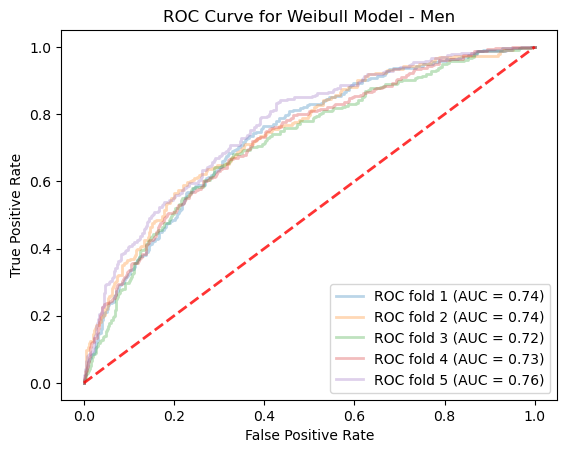

Cross-validation ROC AUC scores for Men: [0.7366451513754418, 0.743436001009846, 0.7160299361310293, 0.7281030868213693, 0.7626734505087881]
Mean ROC AUC score for Men: 0.7373775251692949


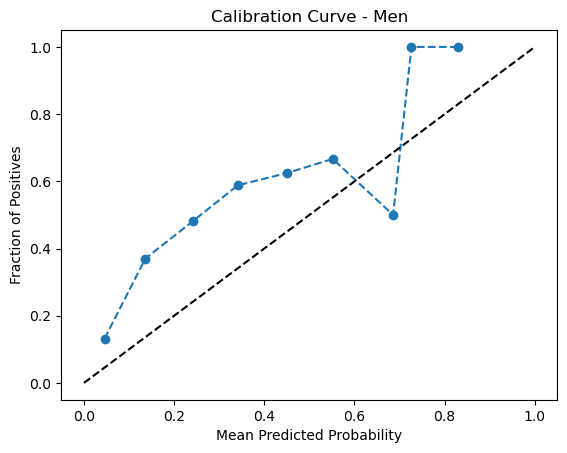

Calibration points for Men:
Mean Predicted: 0.05, Fraction of Positives: 0.13
Mean Predicted: 0.14, Fraction of Positives: 0.37
Mean Predicted: 0.24, Fraction of Positives: 0.48
Mean Predicted: 0.34, Fraction of Positives: 0.59
Mean Predicted: 0.45, Fraction of Positives: 0.62
Mean Predicted: 0.55, Fraction of Positives: 0.67
Mean Predicted: 0.69, Fraction of Positives: 0.50
Mean Predicted: 0.73, Fraction of Positives: 1.00
Mean Predicted: 0.83, Fraction of Positives: 1.00


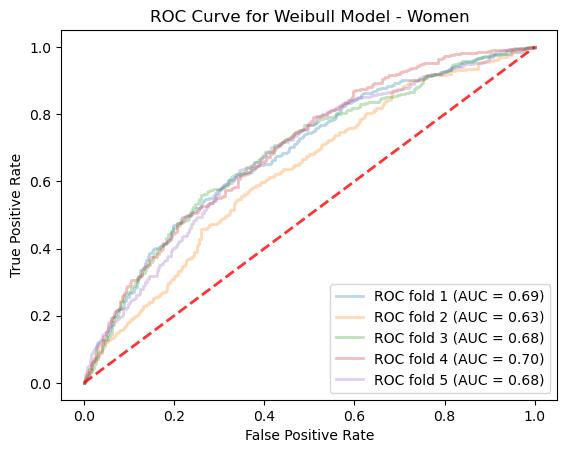

Cross-validation ROC AUC scores for Women: [0.6855616139585605, 0.6311837141433554, 0.6846255270818918, 0.6976414298290026, 0.6795902285263987]
Mean ROC AUC score for Women: 0.6757205027078419


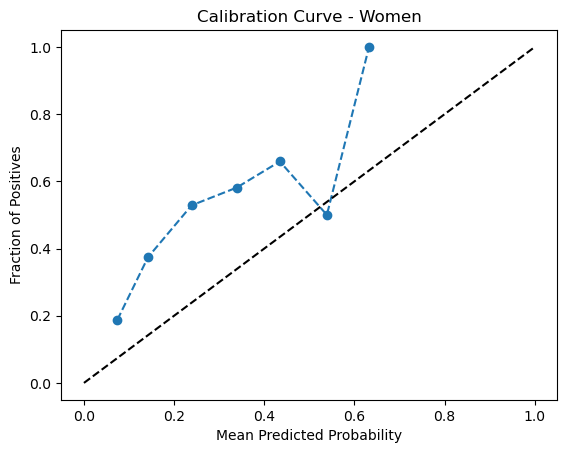

Calibration points for Women:
Mean Predicted: 0.07, Fraction of Positives: 0.19
Mean Predicted: 0.14, Fraction of Positives: 0.37
Mean Predicted: 0.24, Fraction of Positives: 0.53
Mean Predicted: 0.34, Fraction of Positives: 0.58
Mean Predicted: 0.43, Fraction of Positives: 0.66
Mean Predicted: 0.54, Fraction of Positives: 0.50
Mean Predicted: 0.63, Fraction of Positives: 1.00


In [18]:
from sklearn.calibration import calibration_curve

def evaluate_model(model_data, gender, time_horizon=3650):
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cox = CoxPHFitter()
    roc_auc_scores = []

    for train_index, test_index in kf.split(model_data):
        train_data = model_data.iloc[train_index]
        test_data = model_data.iloc[test_index]

        cox.fit(train_data, duration_col='duration', event_col='event')
        # Predict the risk of the event at the specified time horizon
        survival_prob = cox.predict_survival_function(test_data, times=[time_horizon]).T.squeeze()
        predictions = 1 - survival_prob

        fpr, tpr, _ = roc_curve(test_data['event'], predictions)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)

        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(roc_auc_scores), roc_auc))

    # Plot ROC Curve
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Weibull Model - {gender}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Cross-validation ROC AUC scores for {gender}: {roc_auc_scores}")
    print(f"Mean ROC AUC score for {gender}: {np.mean(roc_auc_scores)}")

    # Calibration Curve
    cox.fit(model_data, duration_col='duration', event_col='event')
    survival_prob = cox.predict_survival_function(model_data, times=[time_horizon]).T.squeeze()
    predictions = 1 - survival_prob

    # Calibration curve calculation
    prob_true, prob_pred = calibration_curve(model_data['event'], predictions, n_bins=10)

    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - {gender}')
    plt.show()

    print(f"Calibration points for {gender}:")
    for pt, pp in zip(prob_true, prob_pred):
        print(f"Mean Predicted: {pp:.2f}, Fraction of Positives: {pt:.2f}")

# Evaluate model for men
evaluate_model(model_data_men, 'Men')

# Evaluate model for women
evaluate_model(model_data_women, 'Women')


In [19]:
from sklearn.calibration import calibration_curve

def evaluate_model(model_data, gender, time_horizon=3650):
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cox = CoxPHFitter()
    roc_auc_scores = []
    for train_index, test_index in kf.split(model_data):
        train_data = model_data.iloc[train_index]
        test_data = model_data.iloc[test_index]
        cox.fit(train_data, duration_col='duration', event_col='event')
        # Predict the risk of the event at the specified time horizon
        survival_prob = cox.predict_survival_function(test_data, times=[time_horizon]).T.squeeze()
        predictions = 1 - survival_prob
        fpr, tpr, _ = roc_curve(test_data['event'], predictions)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(roc_auc_scores), roc_auc))
    # Plot ROC Curve
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Cox PH Model - {gender}')
    plt.legend(loc="lower right")
    plt.show()
    print(f"Cross-validation ROC AUC scores for {gender}: {roc_auc_scores}")
    print(f"Mean ROC AUC score for {gender}: {np.mean(roc_auc_scores)}")
    # Calibration Curve
    cox.fit(model_data, duration_col='duration', event_col='event')
    survival_prob = cox.predict_survival_function(model_data, times=[time_horizon]).T.squeeze()
    predictions = 1 - survival_prob
    # Calibration curve calculation
    prob_true, prob_pred = calibration_curve(model_data['event'], predictions, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve - {gender}')
    plt.show()
